# Objective of the Exploration
* Provide summary statistics
    * Descriptive Statistics
* Determine operating cost of individual power plants
* Show how fuel costs impact the viability of the different generation sources
* Highlight the competitiveness of renewable electricity
* Show how the generation mix of different utilities evolved overtime

In [1]:
# import dataframe libraries
import pandas as pd
import numpy as np

In [2]:
# read dataset into dataframe
df = pd.read_csv('raw_data.csv')
df.head(5)

,record_id,utility_id_ferc1,report_year,plant_name_ferc1,fuel_type_code_pudl,fuel_unit,fuel_qty_burned,fuel_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu
0,f1_fuel_1994_12_1_0_7,1,1994,rockport,coal,ton,5377489.0,16.590,18.59,18.53,1.121
1,f1_fuel_1994_12_1_0_10,1,1994,rockport total plant,coal,ton,10486945.0,16.592,18.58,18.53,1.120
2,f1_fuel_1994_12_2_0_1,2,1994,gorgas,coal,ton,2978683.0,24.130,39.72,38.12,1.650
3,f1_fuel_1994_12_2_0_7,2,1994,barry,coal,ton,3739484.0,23.950,47.21,45.99,1.970
4,f1_fuel_1994_12_2_0_10,2,1994,chickasaw,gas,mcf,40533.0,1.000,2.77,2.77,2.570


In [3]:
df.columns

Index(['record_id', 'utility_id_ferc1', 'report_year', 'plant_name_ferc1',
       'fuel_type_code_pudl', 'fuel_unit', 'fuel_qty_burned',
       'fuel_mmbtu_per_unit', 'fuel_cost_per_unit_burned',
       'fuel_cost_per_unit_delivered', 'fuel_cost_per_mmbtu'],
      dtype='object')

In [4]:
# rename columns
df.columns = ['record_id', 'utility_id', 'year', 'plant_name',
              'type', 'unit', 'qty_burned', 'mmbtu_PU',
              'cost_PU_burned', 'cost_PU_delivered', 'cost_per_mmbtu']

### Record Summary

In [5]:
# compute values for summary statistcs
a = len(df)
b = df['utility_id'].nunique()
c = '{}-{}'.format(df['year'].min(), df['year'].max())
d = df['plant_name'].nunique()
e = df['type'].nunique()
f = df['unit'].nunique()

In [6]:
summ = {'Item': ['Records', 'Utilities', 'Period', 'Plants', 'Sources', 'Units'], \
       'Value': [a, b, c, d, e, f]}
sum_table = pd.DataFrame(summ)
sum_table.set_index('Item', inplace=True)
sum_table.transpose()

Item,Records,Utilities,Period,Plants,Sources,Units
Value,29523,185,1994-2018,2315,6,9


## Data Cleaning

In [7]:
# check data types
df.dtypes

record_id             object
utility_id             int64
year                   int64
plant_name            object
type                  object
unit                  object
qty_burned           float64
mmbtu_PU             float64
cost_PU_burned       float64
cost_PU_delivered    float64
cost_per_mmbtu       float64
dtype: object

Every column looks well formatted except year formatted as int64. But since it only contains the year value, it will be left as is.

In [8]:
# check for duplicates
df.duplicated().any()

False

There seems to be no duplicate records

In [9]:
# check for missing values
df.isnull().sum()

record_id              0
utility_id             0
year                   0
plant_name             0
type                   0
unit                 180
qty_burned             0
mmbtu_PU               0
cost_PU_burned         0
cost_PU_delivered      0
cost_per_mmbtu         0
dtype: int64

In [10]:
print('There\'s {}{} missing values in the fuel unit column'.format((df['unit'].isnull().sum() / len(df)).round(3) * 100, '%'))

There's 0.6% missing values in the fuel unit column


In [11]:
df['unit'].unique()

array(['ton', 'mcf', 'kgU', 'bbl', 'gramsU', nan, 'mwdth', 'mmbtu',
       'mwhth', 'gal'], dtype=object)

Only unit column has missing values. Because the missing values are only 0.6% of the lenght of the records, and since it's relating to fuel type, the missing values will be filled with the most occured (mode) unit for each fuel type.

In [12]:
df['unit'] = df.groupby('type')['unit'].apply(lambda x : x.fillna(x.value_counts().index[0]))

In [13]:
# comfirm imputation
df['unit'].isnull().sum()

0

Round all figures to two decimal places

In [14]:
cols = ['mmbtu_PU', 'cost_PU_burned', 'cost_PU_delivered',
       'cost_per_mmbtu']

In [15]:
df[cols] = df[cols].apply(lambda x : x.round(2))

In [16]:
df.head(2)

,record_id,utility_id,year,plant_name,type,unit,qty_burned,mmbtu_PU,cost_PU_burned,cost_PU_delivered,cost_per_mmbtu
0,f1_fuel_1994_12_1_0_7,1,1994,rockport,coal,ton,5377489.0,16.59,18.59,18.53,1.12
1,f1_fuel_1994_12_1_0_10,1,1994,rockport total plant,coal,ton,10486945.0,16.59,18.58,18.53,1.12


## Feature Engineering
From exloration and understanding of the dataset, it was discovered that fuel cost per unit burned is already in mmbtu because fuel cost per mmbtu multiplied by fuel mmbtu per unit is equals to fuel cost per unit burned with few approximation lapses. Therefore, fuel cost per unit burned is the fuel cost in mmbtu. <br>
Based on the above, three new features will be created.
* Total Energy will be created by multiplying quantity burned by fuel mmbtu per unit.
* Total Energy/Fuel cost will be created by multiplying total energy by fuel cost per mmbtu
* Electricity/kWh will be created by dividing total energy by 3412.

In [17]:
df['total_energy'] = (df['qty_burned'] * df['mmbtu_PU']).round(2)
df['total_energy/fuel_cost'] = (df['total_energy'] * df['cost_per_mmbtu']).round(2)
df['kWh'] = (df['total_energy'] / 3412).round(2)

## Summary Statistics

In [18]:
# check desccriptive statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
utility_id,29523.0,1.186018e+02,7.417835e+01,1.00,55.000,122.00,1.760000e+02,5.140000e+02
year,29523.0,2.005806e+03,7.025483e+00,1994.00,2000.000,2006.00,2.012000e+03,2.018000e+03
qty_burned,29523.0,2.622119e+06,9.118004e+06,1.00,13817.000,253322.00,1.424034e+06,5.558942e+08
mmbtu_PU,29523.0,8.491992e+00,1.060027e+01,0.00,1.020,5.76,1.701000e+01,3.412600e+02
cost_PU_burned,29523.0,2.086490e+02,2.854490e+03,-276.08,5.205,26.00,4.711000e+01,1.393580e+05
cost_PU_delivered,29523.0,9.175704e+02,6.877593e+04,-874.94,3.780,17.37,4.213500e+01,7.964521e+06
cost_per_mmbtu,29523.0,1.930434e+01,2.091541e+03,-41.50,1.940,4.13,7.745000e+00,3.592780e+05
total_energy,29523.0,1.444295e+07,1.024990e+08,0.00,33861.870,468917.00,1.248096e+07,1.284672e+10
total_energy/fuel_cost,29523.0,2.999413e+07,1.505306e+08,-19526.58,244489.150,2722800.08,2.682217e+07,1.888467e+10
kWh,29523.0,4.232986e+03,3.004073e+04,0.00,9.925,137.43,3.657960e+03,3.765157e+06


In [19]:
# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib.dates as mdates

In [20]:
cols = ['qty_burned', 'mmbtu_PU', 'cost_PU_burned', 'cost_PU_delivered', 'cost_per_mmbtu', 'total_energy', 'total_energy/fuel_cost', 'kWh']

<Figure size 432x288 with 0 Axes>

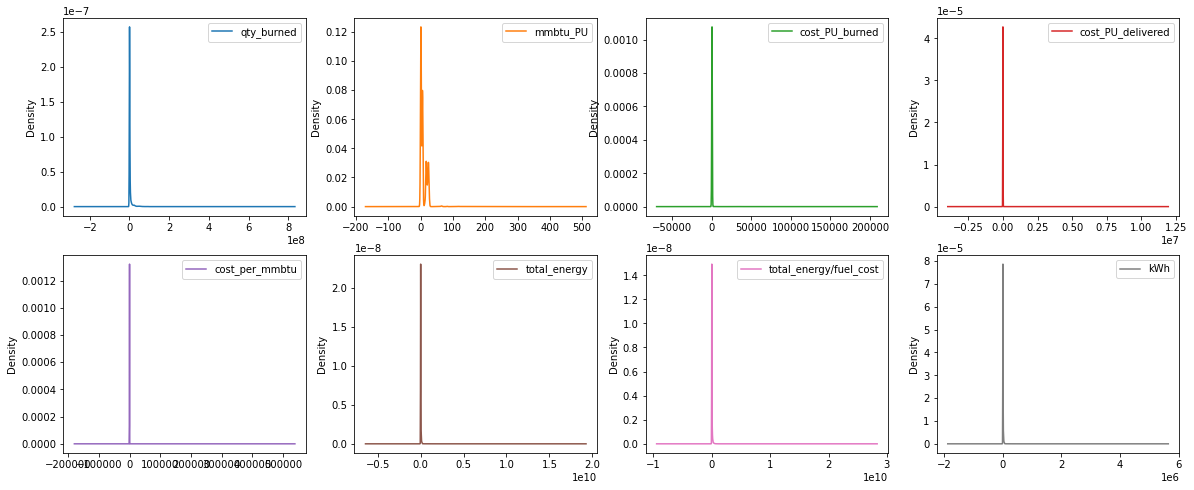

In [21]:
fig = plt.figure()
df[cols].plot(kind='kde', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(20,8))
plt.show()

In [22]:
for i in cols:
    print('{}\'s skewness: \t {}'.format(i, df[i].skew()))

qty_burned's skewness: 	 15.851495469109503
mmbtu_PU's skewness: 	 4.135151916043881
cost_PU_burned's skewness: 	 19.787439826592514
cost_PU_delivered's skewness: 	 105.01422662518937
cost_per_mmbtu's skewness: 	 171.6755346151182
total_energy's skewness: 	 88.47660223628358
total_energy/fuel_cost's skewness: 	 78.48172910810555
kWh's skewness: 	 88.4766022574383


In [23]:
for i in cols:
    print('{}\'s kurtosis: \t {}'.format(i, df[i].kurt()))

qty_burned's kurtosis: 	 651.3694501337732
mmbtu_PU's kurtosis: 	 55.59469155678775
cost_PU_burned's kurtosis: 	 485.25585249640216
cost_PU_delivered's kurtosis: 	 11765.054226412636
cost_per_mmbtu's kurtosis: 	 29489.13259405285
total_energy's kurtosis: 	 9856.814565043
total_energy/fuel_cost's kurtosis: 	 8922.121250232434
kWh's kurtosis: 	 9856.814566032659


The distribution plots and skewness analysis above show that the dataset is skewed to the right. Since missing values were only found in the categorical variable column and have been dealth with, this indicates that there are outliers in the dataset.

### Replacing outliers with median values using iter-quartile range method

In [24]:
# replace outliers with median value as mean value is affected by outliers
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1 * 1.5
df[cols] = np.where(((df[cols] > Q3 + IQR) | (df[cols] < Q1 - IQR)), df[cols].median(), df[cols])

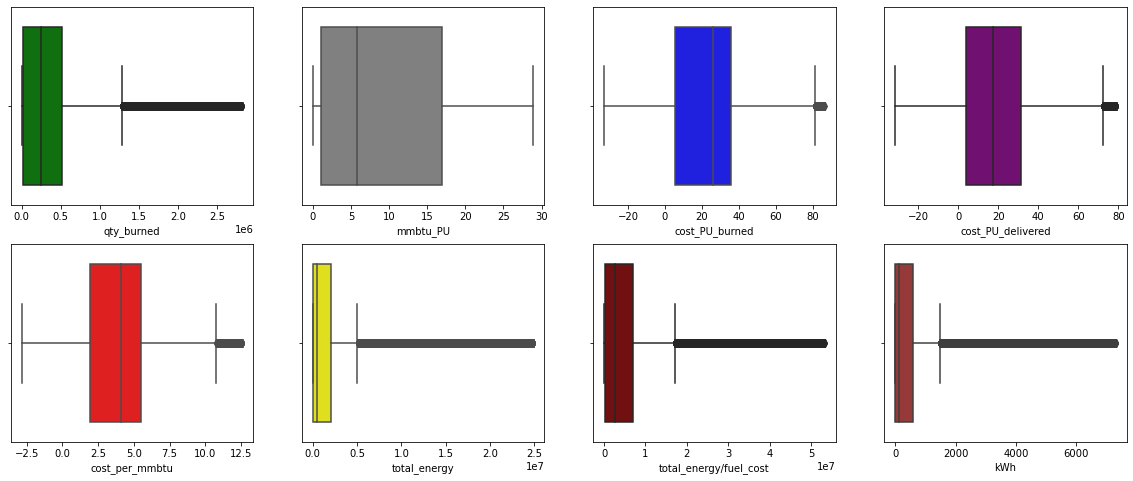

In [25]:
# show boxplot after removing outliers
fig = plt.figure(figsize=(20,8))
ax0 = fig.add_subplot(2,4,1)
ax1 = fig.add_subplot(2,4,2)
ax2 = fig.add_subplot(2,4,3)
ax3 = fig.add_subplot(2,4,4)
ax4 = fig.add_subplot(2,4,5)
ax5 = fig.add_subplot(2,4,6)
ax6 = fig.add_subplot(2,4,7)
ax7 = fig.add_subplot(2,4,8)
sns.boxplot(df[cols[0]], ax=ax0, color='g')
sns.boxplot(df[cols[1]], ax=ax1, color='grey')
sns.boxplot(df[cols[2]], ax=ax2, color='b')
sns.boxplot(df[cols[3]], ax=ax3, color='purple')
sns.boxplot(df[cols[4]], ax=ax4, color='red')
sns.boxplot(df[cols[5]], ax=ax5, color='yellow')
sns.boxplot(df[cols[6]], ax=ax6, color='maroon')
sns.boxplot(df[cols[7]], ax=ax7, color='brown')
plt.show()

Seeing the visualzation above, it becomes clear that the most used source of electricity from 1994 to 2018 used gas, followed by coal. Save the _other_ category, the least generated is waste.

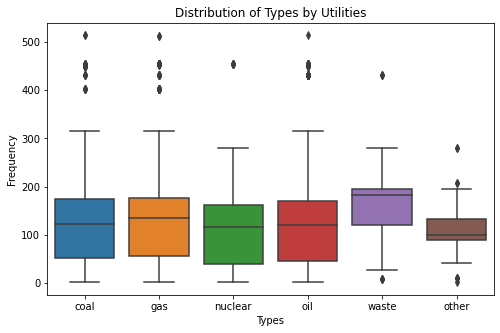

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.boxplot(x='type', y='utility_id', data=df)
ax.set_title('Distribution of Types by Utilities')
ax.set_xlabel('Types')
ax.set_ylabel('Frequency')
plt.show()

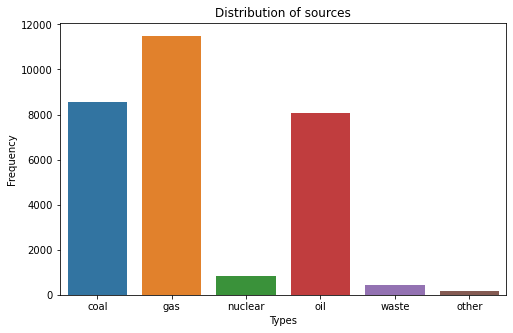

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(df['type'])
ax.set_title('Distribution of sources')
ax.set_xlabel('Types')
ax.set_ylabel('Frequency')
plt.show()

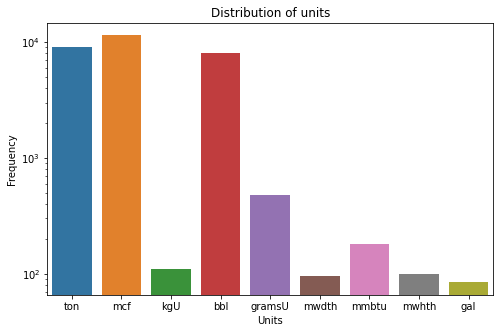

In [28]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(df['unit'])
ax.set_title('Distribution of units')
ax.set_xlabel('Units')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
plt.show()

In [29]:
#jtplot.style(theme='monokai', context='notebook', fscale=1.5, spines=True)

In [30]:
gen = df.groupby(['year', 'type'], as_index=False).agg({'total_energy':'sum'})

In [31]:
mix = pd.concat([gen.loc[gen['type'] == 'coal', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'gas', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'nuclear', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'oil', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'waste', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'other', ['year', 'total_energy']].set_index('year')], join='outer', axis=1)
mix.columns = ['coal', 'gas', 'nuclear', 'oil', 'waste', 'other']

A helper function will be created to show the energy mix for different years.

In [99]:
color = ['#050516', 'maroon', '#6C674A', 'magenta', '#007ED6', '#FF7300']
def plot_mix(year):
    mix_chart = mix.loc[year]
    mix_chart.plot(kind='pie',
                 colors = color,
                 figsize=(10,6),
                 startangle=(90),
                 pctdistance=0.6,
                 explode=[0,0,0.1,0.1,0.1,0.1], frame=True,
                 autopct=None, labels=None, legend=True),
    plt.title('Energy mix by source in {}'.format(mix_chart.name))
    plt.ylabel('')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

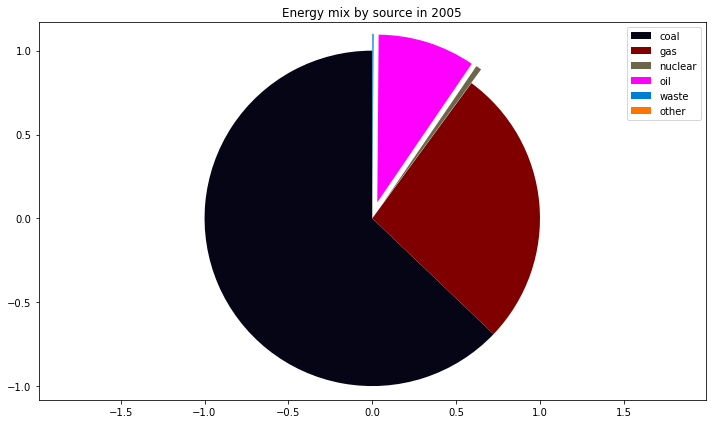

In [100]:
# show plot for specified year
plot_mix(2005)

The pie chart above shows the mix of the six different genration sources for every year. To see the mix for another year, simply change the year in the plot function.

## Operational Cost
Based on the information available in the dataset, to dermine operational cost for each plant, fuel cost will be added to delivery cost. Delivery cost will be calculated by multiplying fuel_cost_per_unit_delivered by qty_burned.

In [33]:
df['delivery_cost'] = df['qty_burned'] * df['cost_PU_delivered']
df['operational_cost'] = df['total_energy/fuel_cost'] + df['delivery_cost']

Now that operational cost has been determined. The dataframe will be grouped by plant name and operational cost used as the value.

In [34]:
plant_cost = df.groupby(['year', 'plant_name'], as_index=False).agg({'operational_cost':'sum'})
plant_cost.head()

,year,plant_name,operational_cost
0,1994,(1)sta98,231374.09
1,1994,(2) scriba sta. 99,136053.83
2,1994,(n)(t)moss landing,2722800.08
3,1994,* campbell 3,71393488.44
4,1994,* decordova,4375976.85


In [35]:
plant_cost['plant_name'].nunique()

2315

### Showing how fuel costs impact the viability of the different generation sources
The objective here is to match the cost of different sources against their demand and show how demand respond to fuel cost. A good indicator for demand in this context would be quantity burned, and it would be matched with fuel cost per unit. However, it would be more appropriate to use the fuel market price per unit.

In [36]:
impact = df.groupby(['year', 'type'], as_index=False).agg({'cost_PU_burned':'mean', 'qty_burned':'mean'})

In [37]:
impact.head()

,year,type,cost_PU_burned,qty_burned
0,1994,coal,31.546505,792678.966316
1,1994,gas,4.113101,287852.874743
2,1994,nuclear,24.510141,559563.661972
3,1994,oil,33.352289,8853.710843
4,1994,other,9.725833,424538.166667


A helper function will be created to show the chart for each fuel type

Having grouped the dataframe, gas will be used as a case.

In [63]:
from sklearn.preprocessing import MinMaxScaler

In [82]:
def plot_impact(fuel_type):
    fueltype = impact.loc[impact['type'] == fuel_type, ['year', 'cost_PU_burned', 'qty_burned']]
    fueltype[['cost_PU_burned', 'qty_burned']] = MinMaxScaler().fit_transform(fueltype[['cost_PU_burned', 'qty_burned']])

    fueltype_melt = pd.melt(fueltype, id_vars='year', value_vars=['cost_PU_burned', 'qty_burned'])

    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.lineplot(x='year', y='value', hue='variable', data=fueltype_melt)
    ax.set_title('Impact of fuel cost on viability of %s source' % fuel_type.capitalize())
    ax.set_xlabel('Year')
    ax.set_ylabel('')
    ax.set_xlim(1994,2018)
    plt.xticks(np.arange(1994, 2018+1, 2))
    ax.legend(loc='best', handlelength=1)
    plt.show()

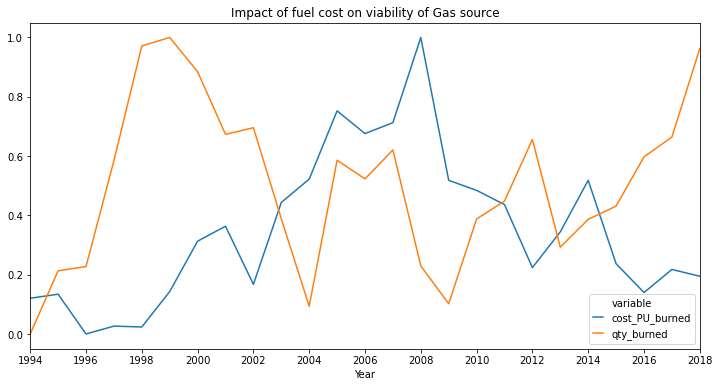

In [83]:
# show plot for specified fuel type
plot_impact('gas')

Without having to check the correlation of these two variables, the line plot shows that fuel cost has a negative impact on the viability of gas as a generation source. As it is shown in the graph the quantity of gas demanded for (quantity burned) reduces as the unit price increases.

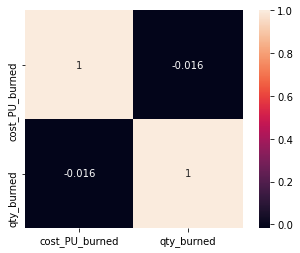

In [87]:
fig, ax = plt.subplots()
ax = sns.heatmap(df[['cost_PU_burned', 'qty_burned']].corr(), annot=True, square=True)
plt.show()

This correlation map further butresses what is shown in the pre-plotted line chart and also quantifies the strength of the impact fuel cost has on the viabiliy of coal as an electricity generation source.

### Showing competition among sources over time
Since competition refers to the demand of a product compared to the demand of an alternative. The demand for the different sources will be measured with their quantity burned and used as a basis of measuring competition.

A bar chart would have been preferred for this visualization, but considering the lenght of years and the amount of categories. A line plot is chosen as it also gives a good representation of the analysis.

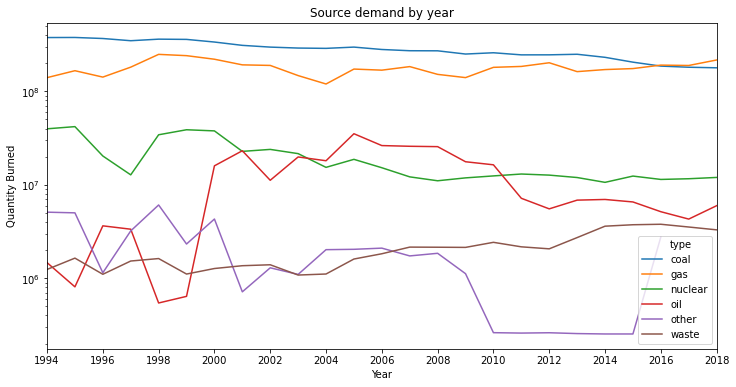

In [40]:
compete = df.groupby(['year', 'type'], as_index=False).agg({'qty_burned':'sum'})
#compete['qty_burned'] = MinMaxScaler().fit_transform(compete['qty_burned'])
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.lineplot(x='year', y='qty_burned', hue='type', data=compete)
ax.set_title('Source demand by year')
ax.set_xlabel('Year')
ax.set_ylabel('Quantity Burned')
ax.set_xlim(1994,2018)
ax.set_yscale('log')
plt.xticks(np.arange(1994, 2018+1, 2))
ax.legend(loc='lower right')
plt.show()

This line plot gives a good view of how these different sources of energy have competed over the years. Coal seems to have been toping the market with gas as its major competitor, but it's interesting to see how gas has taken the top towards the end of 2016. It is also noteworthy, the huge amount of increase in the demand of oil after 1998 and how it has tried to keep the position stable until 2005.

### Showing how the generation mix of different utilities evolved overtime

The first step will be to check the number of unique utilities provided in the dataset

In [46]:
print('There are %s unique Utilities in the dataset' % df['utility_id'].nunique())

There are 185 unique Utilities in the dataset


In [50]:
utility_mix = df.groupby(['year', 'utility_id', 'type'], as_index=False)['total_energy'].sum()

Now, a helper function will be created to show the energy mix for each utility in a bar plot.

In [84]:
def plot_mix(utility_id):
    utility = utility_mix.loc[utility_mix['utility_id'] == utility_id, ['year', 'type', 'total_energy']]
    
    fig, ax = plt.subplots(figsize=(20,6))
    ax = sns.barplot(x='year', y='total_energy', hue='type', data=utility)
    ax.set_title('Generation mix of Utility %s by year' % utility_id)
    ax.set_xlabel('Year')
    ax.set_ylabel('Energy Generated')
    ax.set_yscale('log')
    ax.legend(loc='upper right', handlelength=1)
    plt.show()

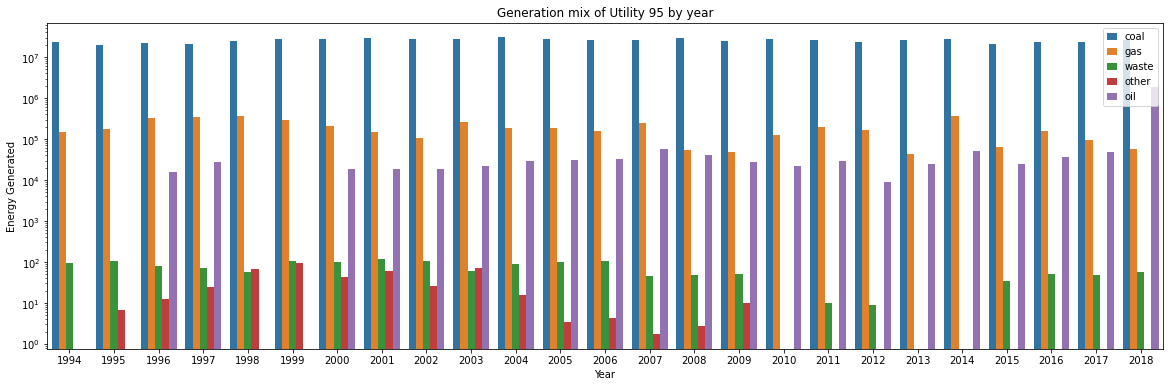

In [86]:
plot_mix(95)